## 准备工作

### 导入库

In [1]:
import sys
sys.path.append("..")
import os
import torch
import torch.nn as nn
import torchpal as tp
import pandas as pd

### 准备数据

In [2]:
NUM_TRAIN_SAMPLES = 500
NUM_TEST_SAMPLES = 100
NUM_FEATURES = 10

# 实际使用中，应确保数据已进行必要的预处理
# 训练集
train_df = pd.DataFrame(
    {"id": range(NUM_TRAIN_SAMPLES)} | 
    {"feature_" + str(i): torch.randn(NUM_TRAIN_SAMPLES) for i in range(NUM_FEATURES)}
)
X_train = torch.tensor(train_df.drop(columns=["id"]).values)
y_train = (X_train[:, 0] ** 2 + X_train[:, 1] * 3 + X_train[:, 2] * 4 + 5).reshape(-1,1)       # 假设只跟前3个特征有关
# 测试集
test_df = pd.DataFrame(
    {"id": range(NUM_TEST_SAMPLES)} | 
    {"feature_" + str(i): torch.randn(NUM_TEST_SAMPLES) for i in range(NUM_FEATURES)}
)  # 注意：test_df 的创建仅为示例，实际应加载你的测试集 DataFrame，例如：pd.read_csv("test.csv")
X_test = torch.tensor(test_df.drop(columns=["id"]).values)

### 定义你自己的模型

In [3]:
class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, X):
        return self.net(X)

## 调用 torchpal

In [4]:
# 初始化 torchpal 管理器
manager = tp.train.RegressionManager(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    net_cls=MyModel,
    net_params={"input_dim": X_train.shape[1], "hidden_dim": 64, "output_dim": 1},
    criterion_cls=nn.MSELoss,
    criterion_params={},
    optimizer_cls=torch.optim.Adam,
    optimizer_params={"lr": 0.005, "weight_decay": 0.01},
    # device="cpu" # 如果不支持cuda，请取消注释此行
)

--- 探索性训练 ---
检测到weight_decay，已自动临时视作0以屏蔽该参数


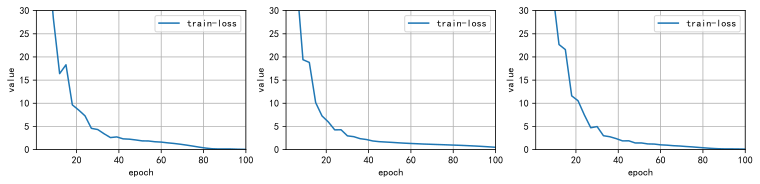

<Figure size 640x480 with 0 Axes>

In [5]:
# 探索性训练：在小数据集上快速验证
print("--- 探索性训练 ---")
manager.exploratory_train(subset_size=50, num_epochs=100, ylim=(0, 30))


--- K 折交叉验证 ---


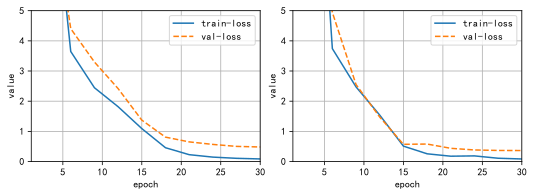

<Figure size 640x480 with 0 Axes>

In [6]:
# 训练与评估。（支持 K 折交叉验证）
print("\n--- K 折交叉验证 ---")
manager.train_and_eval(k_folds=2, batch_size=32, num_epochs=30, ylim=(0, 5))

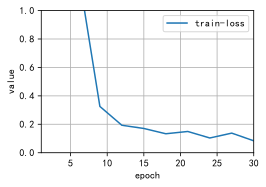

训练完成，已返回模型


<Figure size 640x480 with 0 Axes>

In [7]:
# 最终训练：在完整训练集上训练
final_model = manager.final_train(batch_size=32, num_epochs=30, ylim=(0, 1))

In [8]:
# 预测并保存结果
predictions = manager.predict(
    model=final_model,
    test_df=test_df,  # 包含 ID 列的 DataFrame
    pred_col_name="target",  # 预测列名
    backup_src_path='./test_regression.ipynb',  # 提供路径以备份模型
    # device="cpu"
)

模型：
model=MyModel(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
预测的结果已保存到 d:\Workspace\Vscode\Repos\torchpal\test\submissions\MyModel_0509_131759_pred.csv
Source file backed up to: d:\Workspace\Vscode\Repos\torchpal\test\backups\test_regression_0509_131759.ipynb


## 附：其他功能

### 自定义评估指标

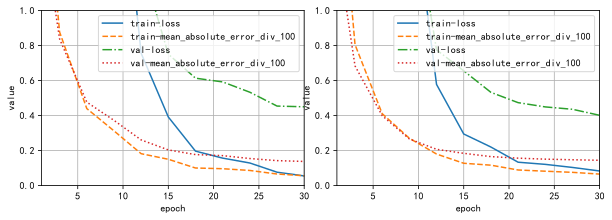

<Figure size 640x480 with 0 Axes>

In [9]:
# 自定义指标格式：(y_hat: torch.Tensor, y: torch.Tensor) -> float
def mean_absolute_error_div_100(y_hat, y):
    return (y_hat - y).abs().sum().item()/100

# 在训练/评估时通过 metric_names 传入自定义指标函数变量 "mae".（"loss", "acc"是内置的特殊名字）
manager.train_and_eval(k_folds=2, batch_size=32, num_epochs=30, metric_names=["loss",mean_absolute_error_div_100])  

### 保存与加载模型

In [10]:
path_str = tp.utils.save_model_state(final_model)  # 默认保存在 state_dicts/

模型状态字典已保存到 d:\Workspace\Vscode\Repos\torchpal\test\state_dicts\MyModel_0509_131806.pth


In [11]:
# 加载模型状态前，需要先实例化一个与保存时结构相同的模型
model_to_load = MyModel(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)
loaded_model = tp.utils.load_model_state(model_to_load, path_str)